<a href="https://colab.research.google.com/github/blogbydev/aiml/blob/main/Starter_code_Assignment_CNN_Skin_Cancer_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-12-25 10:54:22.851891: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [4]:
import os
os.chdir('/content/gdrive/MyDrive/Suyash/aiml/Skin cancer ISIC The International Skin Imaging Collaboration')

In [2]:
# import os
# os.chdir('Skin cancer ISIC The International Skin Imaging Collaboration')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./Train")
data_dir_test = pathlib.Path('./Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [15]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_ds = image_dataset_from_directory(
    data_dir_train,
    seed=123,
    label_mode='int',
    validation_split = 0.2,
    subset = 'training',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


Found 2239 files belonging to 9 classes.


<Axes: ylabel='0'>

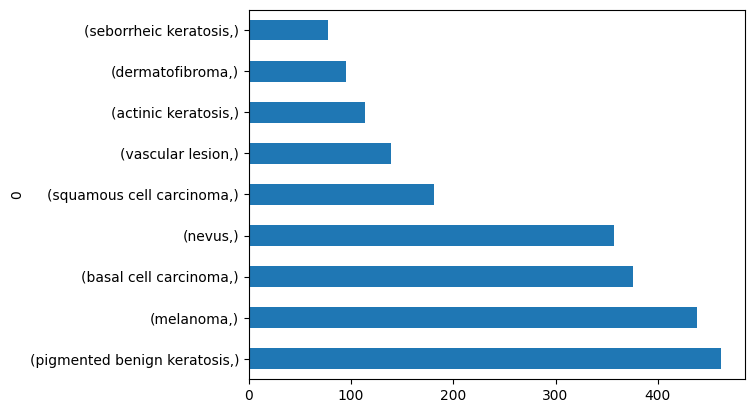

In [7]:
pd.DataFrame([file_path.split('/')[1] for file_path in image_dataset_from_directory(data_dir_train).file_paths]).value_counts().plot.barh()

In [16]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(
    data_dir_train,
    seed=123,
    label_mode='int',
    validation_split = 0.2,
    subset = 'validation',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [17]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [10]:
tf.data.experimental.cardinality(train_ds).numpy()

56

### Visualize the data

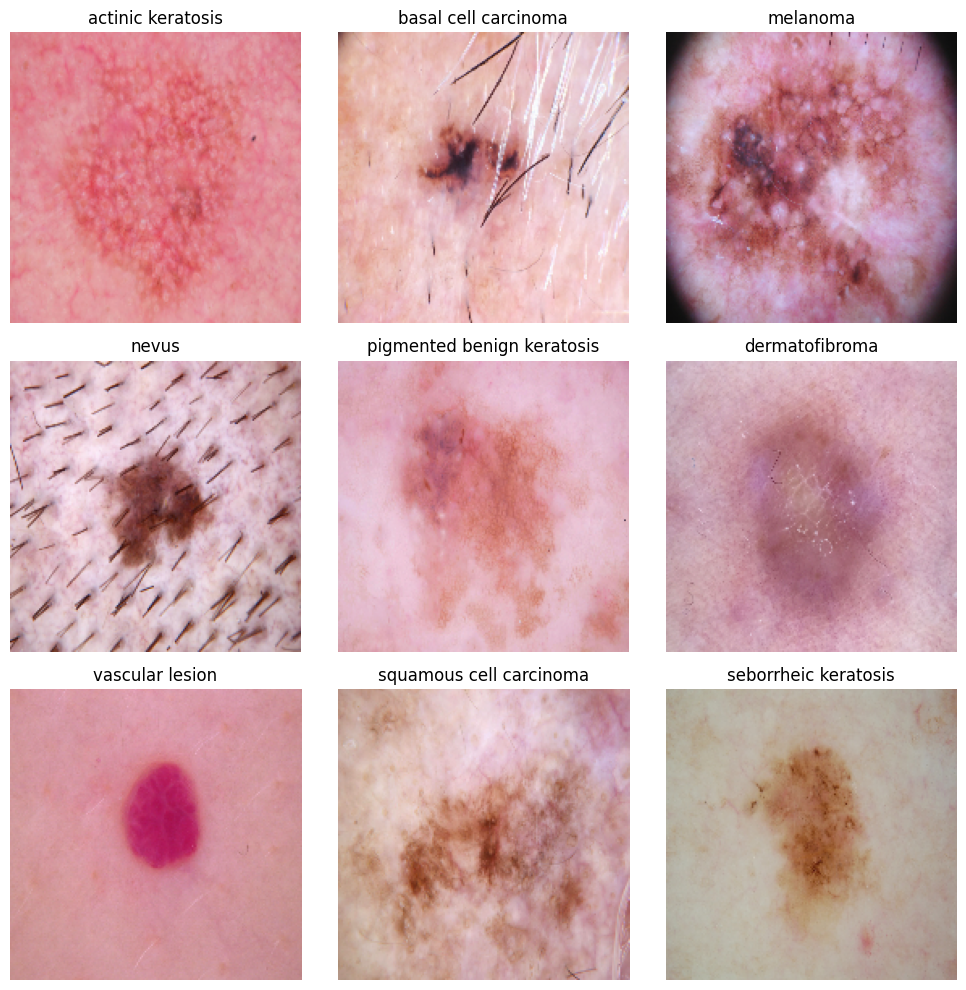

In [25]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
class_images = {}
for images, labels in train_ds:
  for img, label in zip(images, labels):
    label = label.numpy()
    if label not in class_images:
      class_images[label] = [img]
    elif len(class_images) == len(class_names):
      break
  if len(class_images) == len(class_names):
    break

# Plot the images
plt.figure(figsize=(10, 10))
for i, (label, images) in enumerate(class_images.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [27]:
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))

/usr/local/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model

In [29]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 129600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,588,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,609,481 (63.36 MB)

 Trainable params: 16,609,481 (63.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [31]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 658ms/step - accuracy: 0.2106 - loss: 4.2167 - val_accuracy: 0.3266 - val_loss: 1.9499
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 645ms/step - accuracy: 0.2844 - loss: 1.8846 - val_accuracy: 0.4698 - val_loss: 1.6255
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 653ms/step - accuracy: 0.4207 - loss: 1.6283 - val_accuracy: 0.5347 - val_loss: 1.4597
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 679ms/step - accuracy: 0.4975 - loss: 1.4304 - val_accuracy: 0.5548 - val_loss: 1.3963
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 667ms/step - accuracy: 0.5482 - loss: 1.2928 - val_accuracy: 0.4810 - val_loss: 1.5727
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 668ms/step - accuracy: 0.5641 - loss: 1.2632 - val_accuracy: 0.5459 - val_loss: 1.4133
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 698ms/step - accuracy: 0.6182 - loss: 1.1183 - val_accuracy: 0.5235 - val_loss: 1.4847
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 712ms/step - accuracy: 0.6446 - loss: 1.0263 - val_accu

### Visualizing training results

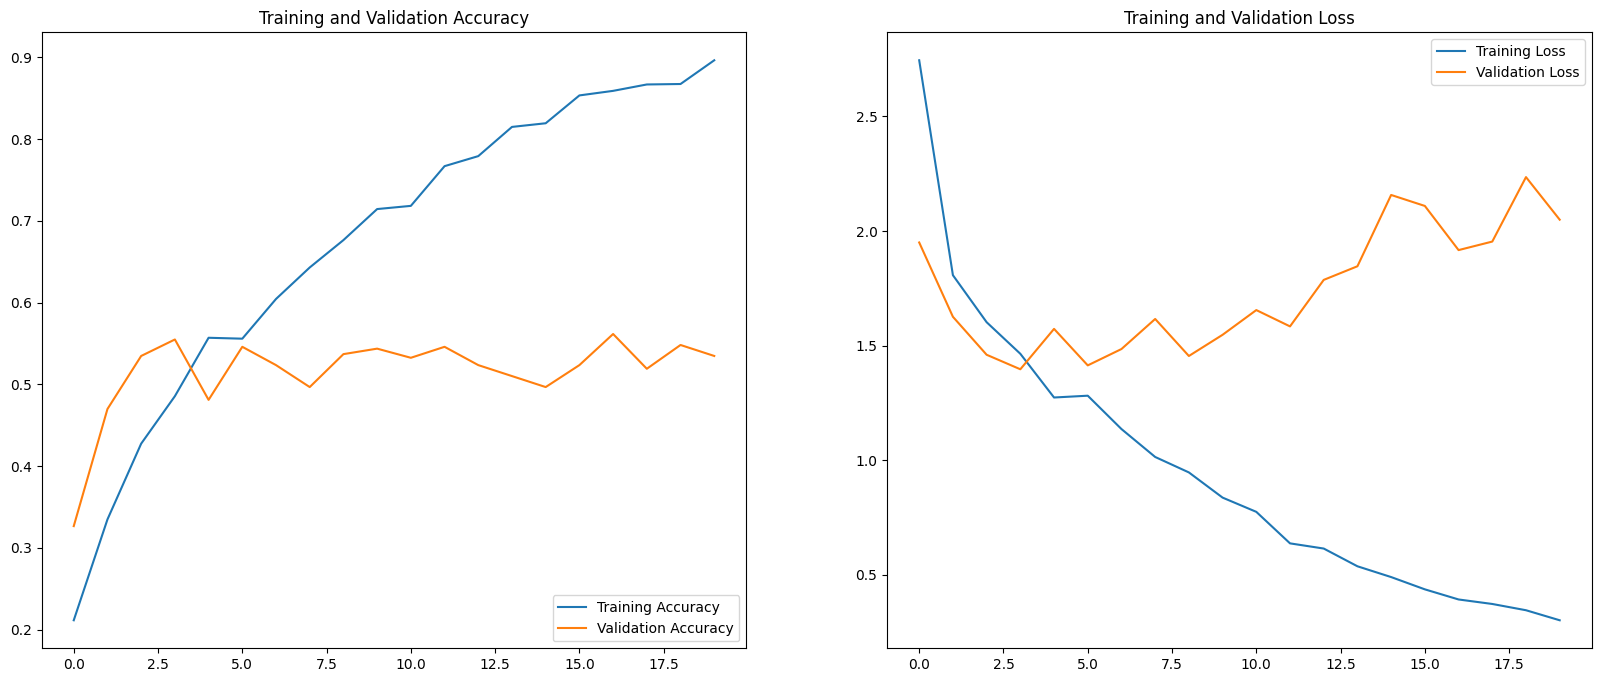

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# there is a clear sign of overfitting

In [33]:
# Data augmentation block
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images
    layers.RandomRotation(0.2),                   # Randomly rotate by 20%
    layers.RandomZoom(0.2),                       # Randomly zoom in/out
    layers.RandomTranslation(0.1, 0.1),           # Randomly shift images
    layers.RandomBrightness(0.2)                  # Adjust brightness
])

augmented_train_dataset = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)


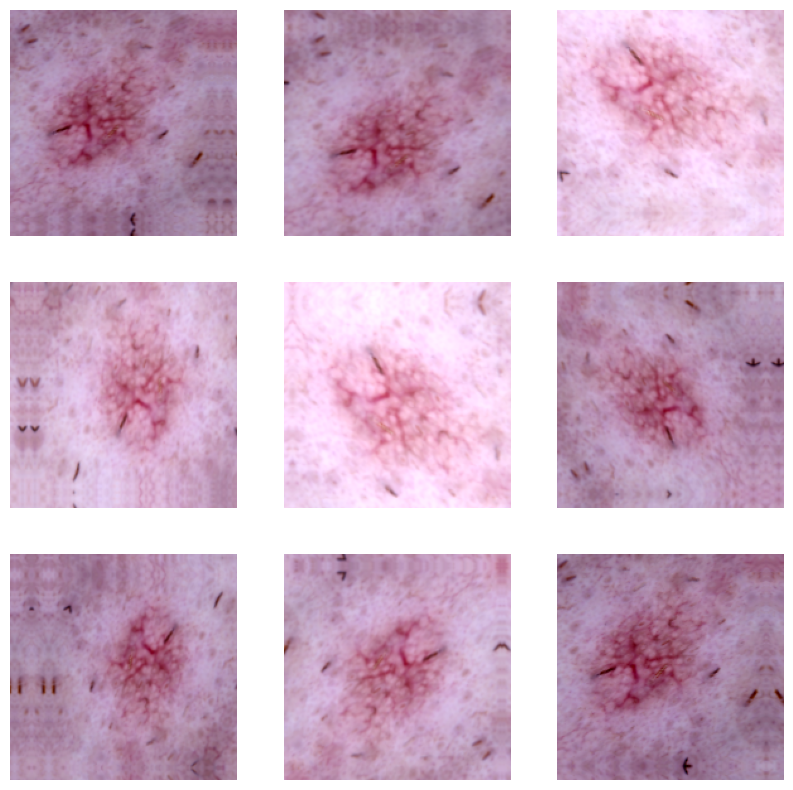

2024-12-25 11:33:00.664037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[2].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

### Create the model, compile and train the model


In [35]:
model = Sequential()
model.add(data_augmentation)
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))

### Compiling the model

In [36]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [37]:
epochs = 20
history = model.fit(
  augmented_train_dataset,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 744ms/step - accuracy: 0.1847 - loss: 3.9019 - val_accuracy: 0.2774 - val_loss: 1.9174
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 54s 965ms/step - accuracy: 0.3146 - loss: 1.8443 - val_accuracy: 0.4072 - val_loss: 1.6854
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.3941 - loss: 1.6918 - val_accuracy: 0.4944 - val_loss: 1.5148
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.4271 - loss: 1.6198 - val_accuracy: 0.4832 - val_loss: 1.5165
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4483 - loss: 1.5473 - val_accuracy: 0.4832 - val_loss: 1.5079
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.4644 - loss: 1.5330 - val_accuracy: 0.5123 - val_loss: 1.4662
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.4537 - loss: 1.4955 - val_accuracy: 0.5145 - val_loss: 1.4683
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4447 - loss: 1.5183 - val_accuracy: 0.5123 - val

### Visualizing the results

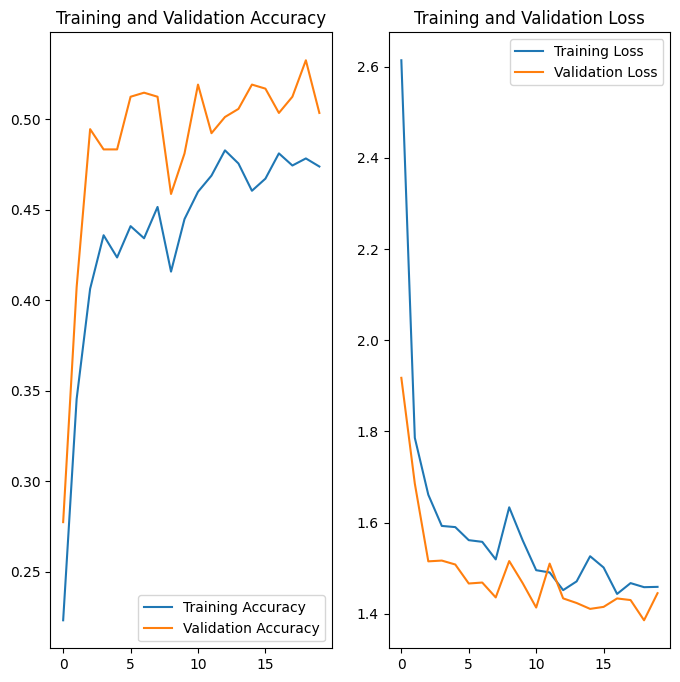

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Found 2239 files belonging to 9 classes.


<Axes: ylabel='0'>

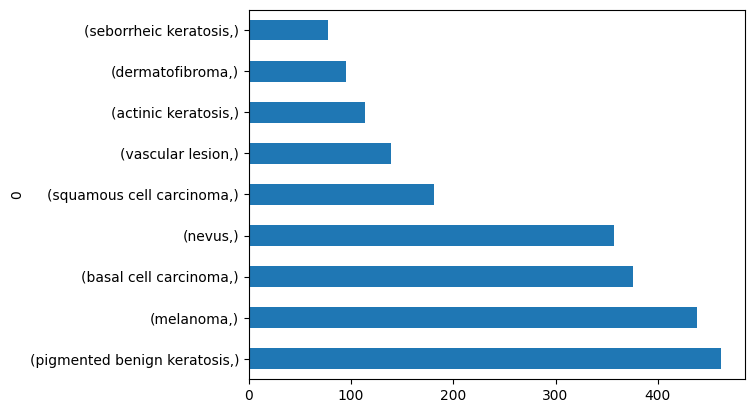

In [39]:
## Your code goes here.
pd.DataFrame([file_path.split('/')[1] for file_path in image_dataset_from_directory(data_dir_train).file_paths]).value_counts().plot.barh()

#### - Which class has the least number of samples?
 - "seborrheic keratosis" has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
 - "nevus, basal cell carcinoma, melanoma, pigmented benign keratosis" dominate the data in terms of sample proportions


In [43]:
%pip install Augmentor

  Using cached Augmentor-0.2.12-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached Augmentor-0.2.12-py2.py3-none-any.whl (38 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /usr/local/Cellar/jupyterlab/4.2.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [41]:
str(data_dir_train.absolute())

'/Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Train'

In [44]:
path_to_training_dataset=str(data_dir_train.absolute())
import Augmentor
for i in class_names:
    print(path_to_training_dataset + i)
    p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Trainactinic keratosis
Initialised with 114 image(s) found.
Output directory set to /Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x13724F140>: 100%|█|


/Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Trainbasal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1


/Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Traindermatofibroma
Initialised with 95 image(s) found.
Output directory set to /Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x138B96180>: 100%|█|


/Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Trainmelanoma
Initialised with 438 image(s) found.
Output directory set to /Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x138B95970>: 100%|█


/Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Trainnevus
Initialised with 357 image(s) found.
Output directory set to /Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0


/Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Trainpigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1


/Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Trainseborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x137971010>: 100%|█


/Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Trainsquamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x13724B860>: 100%|█|


/Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Trainvascular lesion
Initialised with 139 image(s) found.
Output directory set to /Users/suyashs/projects/personal/aiml/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x138BC1520>: 100%|█|


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [45]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [75]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [76]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [48]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [50]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [77]:
df2['Label'].value_counts()

Label
melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [63]:
batch_size = 32
img_height = 180
img_width = 180

In [64]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  label_mode='int',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [65]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  label_mode='int',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [70]:
## your code goes here
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))

In [71]:
## your code goes here
model.compile(optimizer='Adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [73]:
%%time
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 162s 955ms/step - accuracy: 0.4273 - loss: 1.4915 - val_accuracy: 0.1485 - val_loss: 2.6022
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 165s 975ms/step - accuracy: 0.5151 - loss: 1.3002 - val_accuracy: 0.2487 - val_loss: 2.1719
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 160s 946ms/step - accuracy: 0.5564 - loss: 1.1895 - val_accuracy: 0.2814 - val_loss: 6.0304
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 158s 937ms/step - accuracy: 0.6087 - loss: 1.0423 - val_accuracy: 0.3356 - val_loss: 3.4849
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 163s 961ms/step - accuracy: 0.6669 - loss: 0.8908 - val_accuracy: 0.3920 - val_loss: 3.4230
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 164s 968ms/step - accuracy: 0.7233 - loss: 0.7771 - val_accuracy: 0.3838 - val_loss: 3.6478
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 166s 979ms/step - accuracy: 0.7610 - loss: 0.6566 - val_accuracy: 0.5561 - val_loss: 1.5325
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.7927 - lo

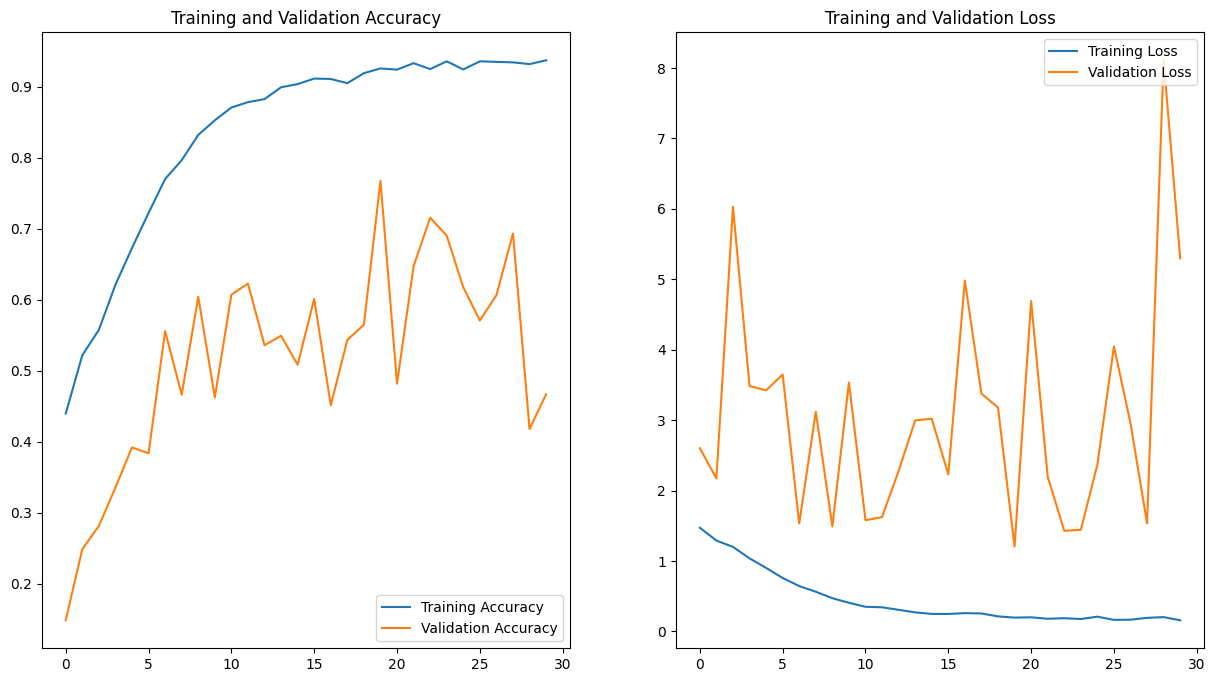

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Test/melanoma/*
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
melanoma


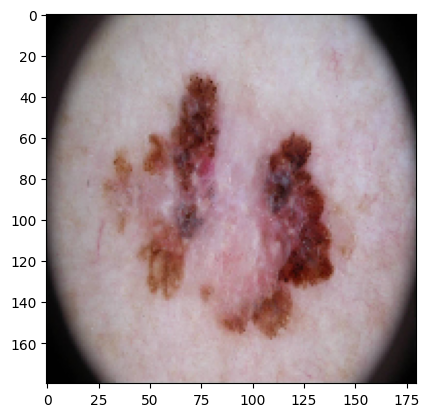

In [107]:
# Model Prediction

import os
from glob import glob
from tensorflow.keras.preprocessing.image import load_img

image_path = os.path.join(data_dir_test, class_names[3], '*')
print(image_path)
image = load_img(glob(image_path)[0], target_size=(180,180,3))
plt.imshow(image)

image = np.expand_dims(image, axis=0)
pred = model.predict(image)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(pred_class)